# 0. Install and Import dependencies

In [2]:
import datetime

# Gym stuff
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# gym trading and finta
from gym_anytrading.envs import StocksEnv
from finta import TA

In [3]:
### data import and data preparation

In [5]:
df = pd.read_csv('data/eurusd_train_set_15_min_simulated.csv', index_col=0)

In [6]:
df

,Price
1992-05-19 00:00:00,1.286500
1992-05-19 00:15:00,1.286803
1992-05-19 00:30:00,1.286329
1992-05-19 00:45:00,1.286024
1992-05-19 01:00:00,1.285228
...,...
2009-12-31 22:45:00,1.430500
2009-12-31 23:00:00,1.430500
2009-12-31 23:15:00,1.431898
2009-12-31 23:30:00,1.431179


In [ ]:
df.columns = ['open', 'high', 'low', 'close']
df.index = pd.to_datetime(df.index)

In [5]:
df.head()

,open,high,low,close
Date,,,,
1983-03-30,29.25,29.56,29.01,29.40
1983-03-31,29.40,29.60,29.25,29.27
1983-04-04,29.30,29.70,29.29,29.44
1983-04-05,29.50,29.80,29.50,29.71
1983-04-06,29.90,29.92,29.65,29.90


In [4]:
df.shape

(10438, 4)

In [4]:
# Assuming your DataFrame is named 'df' and has columns 'open', 'high', 'low', 'close', and 'volume'

# EMA (Exponential Moving Average) - let's compute a 12-period EMA for 'close'
df['EMA_12'] = TA.EMA(df, 12, column='close')

# ATR (Average True Range) - calculating a 14-period ATR
df['ATR_14'] = TA.ATR(df, 14)

# ADX (Average Directional Index) - calculating a 14-period ADX
df['ADX_14'] = TA.ADX(df, 14)

# STOCH (Stochastic Oscillator)
df['STOCH_%K'] = TA.STOCH(df, 14)

# CCI (Commodity Channel Index) - calculating a 20-period CCI
df['CCI_20'] = TA.CCI(df, 20)

In [5]:
df = df.iloc[13:, :]

In [6]:
df_train = df[df.index < '2018-01-01']
df_test = df[df.index >= '2018-01-01']

In [7]:
### environment creation

In [8]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['close', 'EMA_12', 'ATR_14', 'ADX_14', 'STOCH_%K', 'CCI_20']].to_numpy()[start:end]
    return prices, signal_features

In [9]:
train_shape = df_train.shape[0]

In [10]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df_train, window_size=14, frame_bound=(14,train_shape))

In [11]:
### train environment

In [12]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [13]:
model = A2C('MlpPolicy', env, verbose=1) 
model.learn(total_timesteps=train_shape*2)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 460      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.68    |
|    explained_variance | -8.24    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.225   |
|    value_loss         | 0.199    |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 584       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.66     |
|    explained_variance | -3.72e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | 0.204     |
|    valu

In [14]:
### evaluate the model

In [15]:
test_shape = df_test.shape[0]

In [16]:
env = MyCustomEnv(df=df_test, window_size=14, frame_bound=(14,test_shape))
obs = env.reset()[0]

while True: 
    action, _states = model.predict(obs)
    obs, rewards, extra, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': -14.808099999999936, 'total_profit': 0.7549253782474427, 'position': <Positions.Long: 1>}


In [17]:
short_ticks, long_ticks = env.render_all()

In [19]:
def render_all(short_ticks, long_ticks, title, start_date, end_date):
    
    df_test['close'].plot(color='blue')
    
    prices = df_test['close'].values

    plt.plot(df_test.index[short_ticks], prices[short_ticks], 'ro')
    plt.plot(df_test.index[long_ticks], prices[long_ticks], 'go')

    plt.xlim(start_date, end_date)

    if title:
      plt.title(title)

In [23]:
import datetime

In [24]:
datetime.datetime(2018, 1, 1)

datetime.datetime(2018, 1, 1, 0, 0)

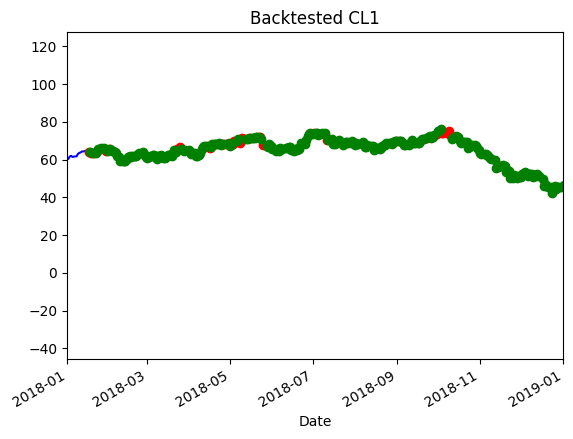

In [25]:
render_all(short_ticks, long_ticks, 'Backtested CL1', datetime.datetime(2018, 1, 1), datetime.datetime(2019, 1, 1))

In [35]:
import plotly.graph_objects as go

# Assuming `df` is your DataFrame with columns 'Close' for closing prices
# and 'Decision' for buy/sell decisions

fig = go.Figure()

prices = df_test['close'].values

# Add the closing prices line
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['close'], mode='lines', name='Close'))

# Highlight buy decisions
fig.add_trace(go.Scatter(x=df_test.index[long_ticks], 
                         y=prices[long_ticks],
                         mode='markers', name='Buy', marker=dict(color='green', size=10, symbol='triangle-up')))

# Highlight sell decisions
fig.add_trace(go.Scatter(x=df_test.index[short_ticks], 
                         y=prices[short_ticks],
                         mode='markers', name='Sell', marker=dict(color='red', size=10, symbol='triangle-down')))

# Update layout for better readability
fig.update_layout(title='Trading Decisions Visualization', xaxis_title='Date', yaxis_title='Price', hovermode='closest')

fig.show()

array([[ 60.1128    ,  60.2886    ,  60.0941    , ...,  19.86663274,
         94.26696833, 152.60682462],
       [ 60.2       ,  60.74      ,  60.1       , ...,  22.01154446,
         92.04301075, 139.20811457],
       [ 60.39      ,  61.97      ,  60.28      , ...,  24.83596945,
         93.39805825, 158.67976773],
       ...,
       [ 78.74      ,  79.49      ,  77.52      , ...,  15.63760185,
         49.34333959,  65.87064098],
       [ 78.15      ,  80.67      ,  77.99      , ...,  16.3114934 ,
         67.72983114, 112.22725582],
       [ 79.13      ,  79.3897    ,  77.9636    , ...,  16.91208945,
         60.80638723,  71.0134729 ]])

In [32]:
df_test[short_ticks]

KeyError: "None of [Int64Index([  14,   16,   18,   25,   26,   28,   75,   76,   95,  104,\n            ...\n            1579, 1582, 1586, 1664, 1667, 1669, 1680, 1682, 1683, 1693],\n           dtype='int64', length=295)] are in the [columns]"

In [ ]:
env.max_possible_profit()